In [212]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [243]:
tickers = [
    "AMZN", "GOOG", "TSLA", "CRM", "ADBE", "BIIB", "ISRG", "VRTX", "REGN",
    "ILMN", "EBAY", "BIDU", "NFLX", "BKNG", "LULU", "ADSK", "BRK-B", "BMRN",
    "ALGN", "META", "EA"
]

start_date = "2009-01-01"
end_date = "2022-12-30"
train_date = "2020-12-31"

data = yf.download(
    tickers,
    start=start_date,
    end=end_date
)

[*********************100%***********************]  21 of 21 completed


In [244]:
def get_stock_data(data: pd.DataFrame, stock: str, freq: str = "D") -> pd.DataFrame:
    if stock not in data.columns.levels[1]:
        raise ValueError(f"Stock {stock} not found in the dataset.")
    
    stock_data = data.xs(stock, axis=1, level=1).copy()
    
    stock_data = stock_data.sort_index()

    stock_data["Pct_Return"] = stock_data["Close"].pct_change()

    window_map = {"D": 5, "W": 5, "M": 3}
    window_size = window_map.get(freq, 5)

    stock_data["Pct_Return_MA"] = stock_data["Pct_Return"].rolling(window=window_size).mean()
    stock_data["Volume_MA"] = stock_data["Volume"].rolling(window=window_size).mean()
    stock_data["Volatility"] = stock_data["Pct_Return"].rolling(window=window_size).std()

    if freq == "W":
        stock_data = stock_data.resample("W").mean()
    elif freq == "M":
        stock_data = stock_data.resample("ME").mean()

    stock_data["Future_Pct_Return"] = stock_data["Pct_Return"].shift(-1)

    return stock_data

def normalize_stock_data(stock_data: pd.DataFrame) -> pd.DataFrame:
    stock_data_normalized = stock_data.copy()

    multipliers = {
        "Pct_Return": 1 / stock_data_normalized["Pct_Return"].std(),
        "Pct_Return_MA": 1 / stock_data_normalized["Pct_Return_MA"].std(),
        "Volume_MA": 1 / stock_data_normalized["Volume_MA"].std(),
        "Volatility": 1 / stock_data_normalized["Volatility"].std(),
        "Future_Pct_Return": 1 / stock_data_normalized["Future_Pct_Return"].std()
    }

    for col, multiplier in multipliers.items():
        stock_data_normalized[col] *= multiplier

    return stock_data_normalized


In [245]:
def plot_stock_data(stock_data: pd.DataFrame, stock: str):
    plt.figure(figsize=(12, 6))

    for col in ["Pct_Return", "Pct_Return_MA", "Volume_MA", "Volatility"]:
        plt.plot(stock_data.index, stock_data[col], label=col)

    plt.xlabel("Date")
    plt.ylabel("Scaled Values")
    plt.title(f"{stock} Stock Data Trends")
    plt.legend()
    plt.savefig(f"{stock.lower()}_stock_data_trends.png")
    plt.show()

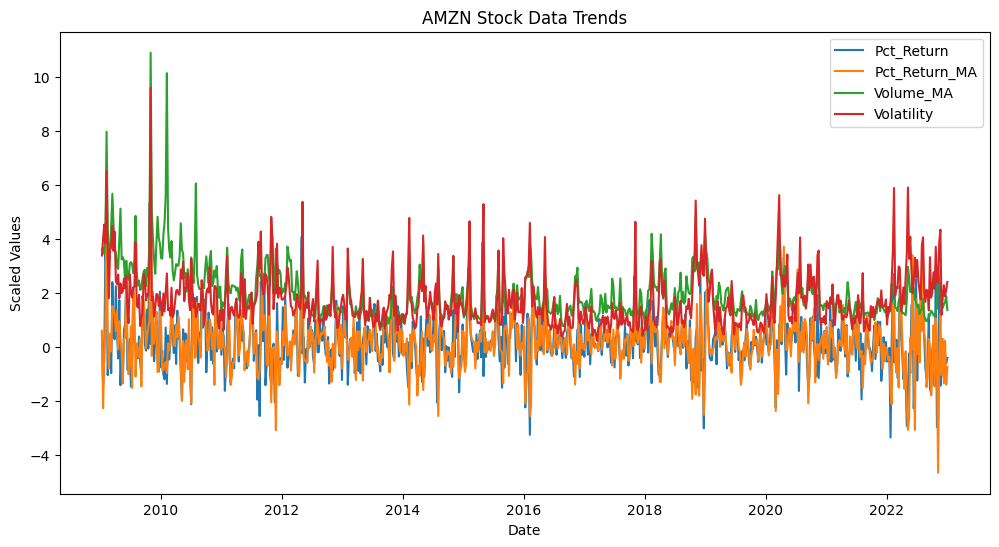

In [246]:
stock_data = get_stock_data(data, "AMZN", "W")
normalized_stock_data = normalize_stock_data(stock_data)
plot_stock_data(normalized_stock_data, "AMZN")

In [247]:
def label_data(stock_data: pd.DataFrame, cut_date: str = train_date) -> tuple:
    stock_data_labeled = stock_data.copy()
    cut_mask = stock_data_labeled.index <= cut_date

    tau = stock_data_labeled.loc[cut_mask, "Future_Pct_Return"].abs().quantile(1/3)

    stock_data_labeled["Label"] = 0
    stock_data_labeled.loc[stock_data_labeled["Future_Pct_Return"] > tau, "Label"] = 1
    stock_data_labeled.loc[stock_data_labeled["Future_Pct_Return"] < -tau, "Label"] = -1

    label_counts = stock_data_labeled.loc[cut_mask, "Label"].value_counts(normalize=True).to_dict()

    return stock_data_labeled, tau, label_counts


In [248]:
def plot_labeled_histogram(stock_data_labeled: pd.DataFrame, stock: str, label_distribution: dict):
    mean_return = stock_data_labeled["Future_Pct_Return"].mean()
    std_return = stock_data_labeled["Future_Pct_Return"].std()

    lower_bound = mean_return - 3 * std_return
    upper_bound = mean_return + 3 * std_return

    plt.figure(figsize=(10, 5))

    bins = np.linspace(lower_bound, upper_bound, 100)

    plt.hist(
        stock_data_labeled[stock_data_labeled["Label"] == -1]["Future_Pct_Return"].dropna(),
        bins=bins, color="red", edgecolor="black", alpha=0.7, label=f"Negative (-1): {label_distribution.get(-1, 0):.2%}"
    )

    plt.hist(
        stock_data_labeled[stock_data_labeled["Label"] == 0]["Future_Pct_Return"].dropna(),
        bins=bins, color="gray", edgecolor="black", alpha=0.7, label=f"Neutral (0): {label_distribution.get(0, 0):.2%}"
    )

    plt.hist(
        stock_data_labeled[stock_data_labeled["Label"] == 1]["Future_Pct_Return"].dropna(),
        bins=bins, color="green", edgecolor="black", alpha=0.7, label=f"Positive (+1): {label_distribution.get(1, 0):.2%}"
    )

    plt.xlabel("Future Pct Return")
    plt.ylabel("Frequency")
    plt.title(f"{stock} Future Percentage Return Distribution (Labeled)")
    plt.legend()
    plt.savefig(f"{stock.lower()}_future_pct_return_distribution.pdf")
    plt.show()


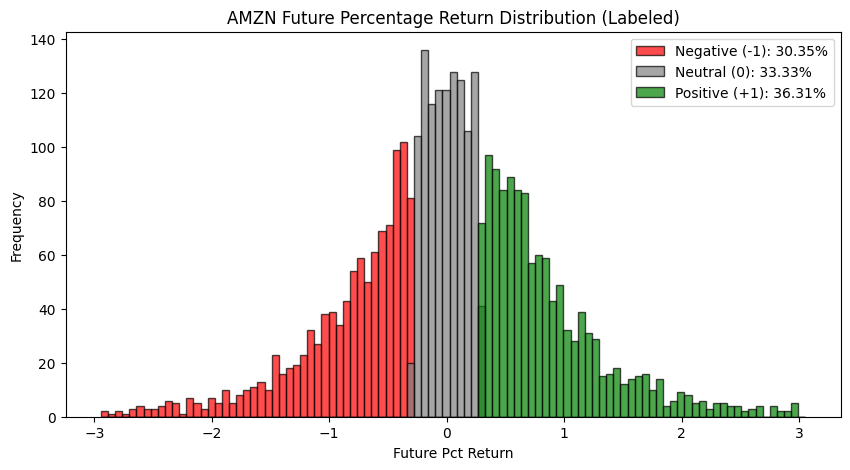

In [249]:
stock_data = get_stock_data(data, "AMZN", "D")
normalized_stock_data = normalize_stock_data(stock_data)
stock_data_labeled, tau, label_counts = label_data(normalized_stock_data)
plot_labeled_histogram(stock_data_labeled, "AMZN", label_counts)

In [ ]:
def calculate_center_of_mass_and_std(normalized_stock_data: pd.DataFrame) -> tuple:
    train_mask = normalized_stock_data.index <= train_date
    train_data = normalized_stock_data.loc[train_mask]

    feature_columns = ["Pct_Return_MA", "Volume_MA", "Volatility"]
    label_categories = train_data["Label"].unique()

    center_of_mass = {}
    std_values = {}

    for feature in feature_columns:
        center_of_mass[feature] = {}
        std_values[feature] = 0

        for label in label_categories:
            label_mask = train_data["Label"] == label
            center_of_mass[feature][label] = train_data.loc[label_mask, feature].mean()

        N = train_data[feature].count()  # Number of non-NA samples
        K = len(label_categories)  # Number of label categories

        variance_sum = 0

        for label in label_categories:
            label_mask = train_data["Label"] == label
            mu_k = center_of_mass[feature][label]

            variance_sum += ((train_data.loc[label_mask, feature] - mu_k) ** 2).sum()

        std_values[feature] = np.sqrt(variance_sum / (N - K))

    return center_of_mass, std_values


In [251]:
stock_data = get_stock_data(data, "AMZN", "D")
normalized_stock_data = normalize_stock_data(stock_data)
stock_data_labeled, tau, label_counts = label_data(normalized_stock_data)
com, std = calculate_center_of_mass_and_std(stock_data_labeled)

In [252]:
def create_center_of_mass_df(center_of_mass: dict, std_values: dict) -> pd.DataFrame:
    df_data = []

    for feature, label_dict in center_of_mass.items():
        row = {
            "Feature": feature,
            "CoM_-1": label_dict.get(-1, np.nan),
            "CoM_0": label_dict.get(0, np.nan),
            "CoM_1": label_dict.get(1, np.nan),
            "Std": std_values.get(feature, np.nan),
        }
        df_data.append(row)

    df = pd.DataFrame(df_data).set_index("Feature")
    return df


In [253]:
print(create_center_of_mass_df(com, std).to_latex(caption=f"Center of Mass and Standard Deviation for Each Feature for AMZN. CoM: center of mass", label="tab:com_std", float_format="{:.2f}".format, escape=True))

\begin{table}
\caption{Center of Mass and Standard Deviation for Each Feature for AMZN. CoM: center of mass}
\label{tab:com_std}
\begin{tabular}{lrrrr}
\toprule
 & CoM\_-1 & CoM\_0 & CoM\_1 & Std \\
Feature &  &  &  &  \\
\midrule
Pct\_Return\_MA & 0.17 & 0.24 & 0.10 & 0.96 \\
Volume\_MA & 2.10 & 1.81 & 2.05 & 1.04 \\
Volatility & 1.55 & 1.30 & 1.52 & 0.98 \\
\bottomrule
\end{tabular}
\end{table}



In [254]:
def classify_test_set(normalized_stock_data: pd.DataFrame, center_of_mass: dict, std_values: dict, label_distribution: dict, train_date: str = "2020-12-31") -> pd.DataFrame:
    test_mask = normalized_stock_data.index > train_date
    test_data = normalized_stock_data.loc[test_mask].copy()
    feature_columns = ["Pct_Return_MA", "Volume_MA", "Volatility"]

    sigma_squared = sum(np.square(list(std_values.values())))  # Sum of sigma squares across features

    for k in [-1, 0, 1]:
        prior = label_distribution.get(k, 0)  # P(y = k)

        # Compute squared Euclidean distance from center of mass
        distance_squared = sum((test_data[feature] - center_of_mass[feature].get(k, 0)) ** 2 for feature in feature_columns)

        # Compute likelihood using the Gaussian formula
        likelihood = (1 / (np.sqrt(2 * np.pi * sigma_squared))) * np.exp(-distance_squared / (2 * sigma_squared))

        # Compute posterior probability
        test_data[f"Prob_{k}"] = prior * likelihood

    test_data["Predicted_Label"] = test_data[["Prob_-1", "Prob_0", "Prob_1"]].idxmax(axis=1).str.extract(r"(-?\d+)").astype(int)

    return test_data


In [255]:
test_predictions = classify_test_set(normalized_stock_data, com, std, label_counts)


In [256]:
test_predictions

Price,Close,High,Low,Open,Volume,Pct_Return,Pct_Return_MA,Volume_MA,Volatility,Future_Pct_Return,Prob_-1,Prob_0,Prob_1,Predicted_Label
Date,,,,,,,,,,,,,,
2021-01-04,159.331497,163.600006,157.201004,163.500000,88228000,-0.985448,0.112857,1.715273,1.829893,0.456747,0.067705,0.073341,0.081242,1
2021-01-05,160.925507,161.169006,158.253006,158.300507,53110000,0.456747,-0.412328,1.469289,1.164844,-1.136651,0.060663,0.070372,0.074495,1
2021-01-06,156.919006,159.875504,156.557999,157.324005,87896000,-1.136651,-1.176641,1.430492,1.115654,0.345933,0.046628,0.053512,0.058342,1
2021-01-07,158.108002,160.427002,157.750000,157.850006,70290000,0.345933,-0.789895,1.455259,1.310703,0.296552,0.055697,0.063303,0.068901,1
2021-01-08,159.134995,159.531998,157.110001,159.000000,70754000,0.296552,-0.469403,1.502365,1.401527,-0.982467,0.061671,0.069774,0.075600,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22,83.790001,85.680000,82.250000,85.519997,81431300,-1.567952,-1.105191,1.804415,1.883958,0.795513,0.051811,0.053738,0.063810,1
2022-12-23,85.250000,85.779999,82.930000,83.250000,57433700,0.795513,-0.600368,1.444482,2.151523,-1.183544,0.055761,0.059297,0.068080,1
2022-12-27,83.040001,85.349998,83.000000,84.970001,57284000,-1.183544,-0.442424,1.337986,2.002840,-0.670748,0.057900,0.063268,0.070667,1


In [ ]:
print(test_predictions["Predicted_Label"].value_counts())

Predicted_Label
1    384
0    118
Name: count, dtype: int64


In [ ]:
def evaluate_classification(normalized_stock_data: pd.DataFrame,
                            center_of_mass: dict,
                            std_values: dict,
                            label_distribution: dict,
                            train_date: str, end_date: str) -> float:
    # Label the full dataset using the full available data range
    labeled_data, _, _ = label_data(normalized_stock_data, cut_date=end_date)

    # Keep only test samples (i.e., those after train_date)
    test_data = labeled_data[labeled_data.index > train_date].copy()

    # Perform classification on the test set
    test_predictions = classify_test_set(test_data, center_of_mass, std_values, label_distribution, train_date)
    print()

    # Compute accuracy
    correct_predictions = (test_predictions["Label"] == test_predictions["Predicted_Label"]).sum()
    total_predictions = test_predictions["Label"].count()

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0

    return accuracy

In [259]:
evaluate_classification(normalized_stock_data, com, std, label_counts, train_date, end_date)

0.3466135458167331

In [278]:
def process_stock(stock: str, data: pd.DataFrame, freq: str) -> float:
    # Get stock data for the given frequency
    stock_data = get_stock_data(data, stock, freq=freq)

    # Normalize stock data
    normalized_stock_data = normalize_stock_data(stock_data)

    # Label the data
    labeled_data, _, label_distribution = label_data(normalized_stock_data, cut_date=end_date)

    # Compute center of mass and standard deviation
    center_of_mass, std_values = calculate_center_of_mass_and_std(labeled_data, train_date=train_date)

    # Classify test set
    classification_accuracy = evaluate_classification(normalized_stock_data, center_of_mass, std_values, label_distribution, train_date, end_date)

    return classification_accuracy

In [261]:
process_stock("AMZN", data)

0.3466135458167331

In [279]:
# Define frequencies to test
frequencies = ["D", "W", "M"]

# Create DataFrame to store results for all frequencies
results = pd.DataFrame(index=tickers, columns=[f"Accuracy_{freq}" for freq in frequencies])

# Populate DataFrame with results for each stock and frequency
for stock in tickers:
    for freq in frequencies:
        results.loc[stock, f"Accuracy_{freq}"] = process_stock(stock, data, freq)

# Compute average accuracy across all stocks for each frequency
average_accuracies = results.mean()

# Print LaTeX table output
print(results.to_latex(caption="Stock Classification Accuracy Results for Different Frequencies",
                       label="tab:results", float_format="{:.2f}".format, escape=True))


\begin{table}
\caption{Stock Classification Accuracy Results for Different Frequencies}
\label{tab:results}
\begin{tabular}{llll}
\toprule
 & Accuracy\_D & Accuracy\_W & Accuracy\_M \\
\midrule
AMZN & 0.36 & 0.30 & 0.25 \\
GOOG & 0.38 & 0.36 & 0.38 \\
TSLA & 0.31 & 0.30 & 0.25 \\
CRM & 0.38 & 0.30 & 0.25 \\
ADBE & 0.38 & 0.43 & 0.38 \\
BIIB & 0.35 & 0.34 & 0.17 \\
ISRG & 0.37 & 0.34 & 0.42 \\
VRTX & 0.40 & 0.32 & 0.21 \\
REGN & 0.39 & 0.37 & 0.33 \\
ILMN & 0.36 & 0.34 & 0.21 \\
EBAY & 0.37 & 0.26 & 0.38 \\
BIDU & 0.30 & 0.30 & 0.33 \\
NFLX & 0.41 & 0.30 & 0.29 \\
BKNG & 0.36 & 0.39 & 0.33 \\
LULU & 0.37 & 0.35 & 0.33 \\
ADSK & 0.31 & 0.30 & 0.46 \\
BRK-B & 0.37 & 0.39 & 0.54 \\
BMRN & 0.39 & 0.31 & 0.29 \\
ALGN & 0.37 & 0.33 & 0.29 \\
META & 0.24 & 0.32 & 0.50 \\
EA & 0.38 & 0.37 & 0.25 \\
\bottomrule
\end{tabular}
\end{table}



In [276]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_training_data(normalized_stock_data: pd.DataFrame):
    train_data = normalized_stock_data[normalized_stock_data.index <= train_date].copy()

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    colors = {1: "green", 0: "gray", -1: "red"}

    for label in [-1, 0, 1]:
        subset = train_data[train_data["Label"] == label]
        ax.scatter(
            subset["Pct_Return_MA"], 
            subset["Volume_MA"], 
            subset["Volatility"], 
            c=colors[label], 
            label=f"Label {label}", 
            alpha=0.4
        )

    ax.set_xlabel("Pct_Return_MA")
    ax.set_ylabel("Volume_MA")
    ax.set_zlabel("Volatility")
    ax.set_title("3D Scatter Plot of Training Data")
    ax.legend()
    plt.savefig("3d_scatter_plot.pdf")
    plt.show()


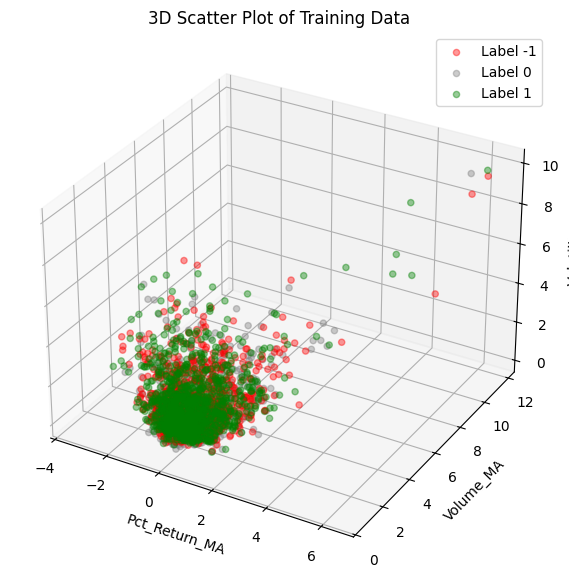

In [277]:
stock_data = get_stock_data(data, "AMZN", "D")
normalized_stock_data = normalize_stock_data(stock_data)
stock_data_labeled, tau, label_counts = label_data(normalized_stock_data)
plot_3d_training_data(stock_data_labeled)

In [270]:
print(normalized_stock_data.tail().__repr__())

Price           Close       High        Low       Open    Volume  Pct_Return  \
Date                                                                           
2022-12-22  83.790001  85.680000  82.250000  85.519997  81431300   -1.567952   
2022-12-23  85.250000  85.779999  82.930000  83.250000  57433700    0.795513   
2022-12-27  83.040001  85.349998  83.000000  84.970001  57284000   -1.183544   
2022-12-28  81.820000  83.480003  81.690002  82.800003  58228600   -0.670748   
2022-12-29  84.180000  84.550003  82.550003  82.870003  54995900    1.316859   

Price       Pct_Return_MA  Volume_MA  Volatility  Future_Pct_Return  
Date                                                                 
2022-12-22      -1.105191   1.804415    1.883958           0.795513  
2022-12-23      -0.600368   1.444482    2.151523          -1.183544  
2022-12-27      -0.442424   1.337986    2.002840          -0.670748  
2022-12-28      -0.816852   1.272582    1.999074           1.316859  
2022-12-29      -0.